In [2]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import scanorama as sca
import harmonypy as ha
import scvi


/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


Since in our dataset batch correction is the most challenging step, we try to benchmark 4 popularly used methods for data integration. We keep normalised and raw counts in our data, as different algorithms have different requirements. All algorithms consider HVG data as all of them work with either PCA or the KNN neighborhood whereas scVI takes HVG raw counts matrix. Additionally, for integration effects visualisation and integration metric calculation, we leverage a preliminary cell annotation devised using scanpy_ rank_genes_groups() DE marker identification on unintegrated data.

In [25]:

alldata = sc.read_h5ad('new_data/umap/alldata_batch.h5ad')
alldata = alldata [:, ~alldata.var_names.duplicated(keep='first')].copy()
alldata_full=sc.read_h5ad('new_data/umap/alldata.h5ad')

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


We inspect the embeddings again for low-quality clusters prior to integration and move forward. For this goal we also add the log_norm counts layer first.

In [26]:
alldata.X=alldata.layers['log1p_norm']

In [27]:
# to reproduce my results though this step should be done in normalisation/clustering
obsm=alldata.obsm.copy()
uns=alldata.uns.copy()
varm=alldata.varm.copy()
obsp = alldata.obsp.copy()
clustering=alldata.obs['leiden_res0.5'].copy()
clustering2=alldata.obs['leiden_res2'].copy()
alldata_full.obsm=obsm
alldata_full.uns=uns
alldata_full.obsp=obsp
alldata_full.obs['leiden_res0.5']=clustering
alldata_full.obs['leiden_res2']=clustering2

In [28]:
alldata_full

AnnData object with n_obs × n_vars = 63530 × 18079
    obs: 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hsps', 'log1p_total_counts_hsps', 'pct_counts_hsps', 'total_counts_strs', 'log1p_total_counts_strs', 'pct_counts_strs', 'ribo_outlier', 'mito_outlier', 'n_counts', 'doublet_scores', 'predicted_doublets', 'sample', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'leiden_res0.5', 'leiden_res2'
    var: 'gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg', 'leiden_res0.5', 'leiden_res2', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 

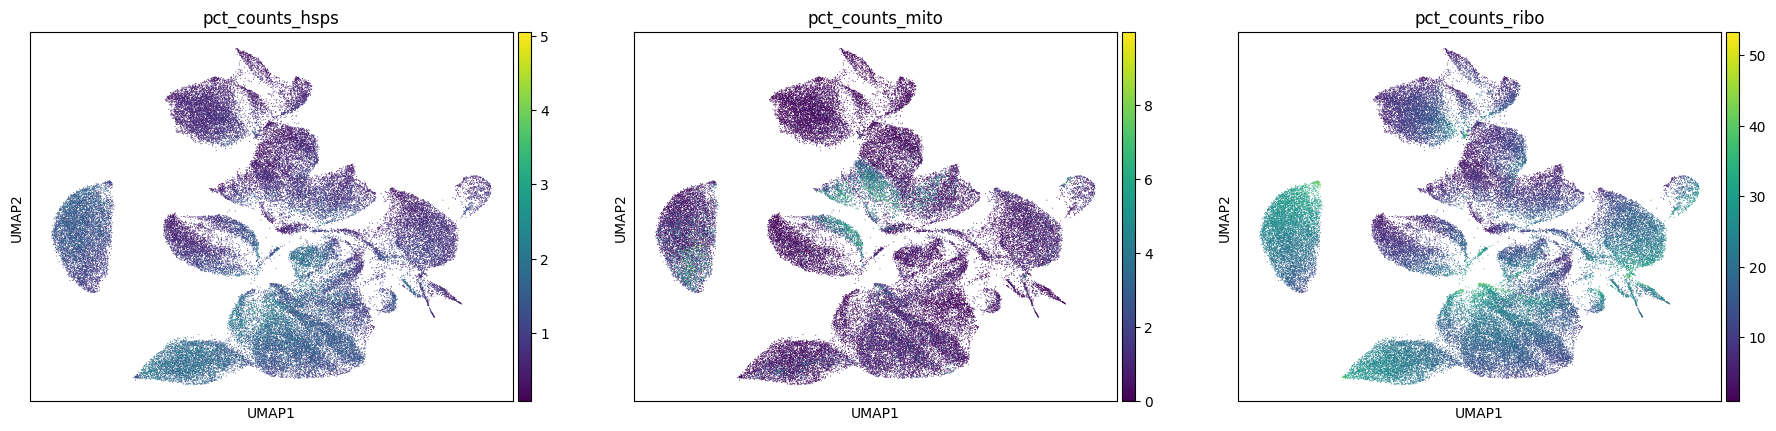

In [29]:
sc.pl.umap(alldata_full, color=['pct_counts_hsps', 'pct_counts_mito', 'pct_counts_ribo'])

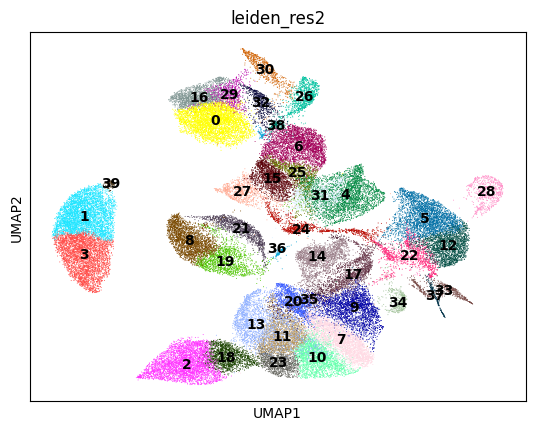

In [31]:
#use the extreme resolution to remove some clusters that do not look good
sc.pl.umap(alldata_full, color=['leiden_res2'], legend_loc='on data')

In [4]:
# remove a suspicious cluster

alldata = alldata[alldata.obs['leiden_res2'] != '36'].copy()
alldata_full = alldata_full[alldata_full.obs['leiden_res2'] != '36'].copy()

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Following are the preliminary annotation labels. 

In [29]:
labels = {'0': 'grmESCs', '1': 'Neurons', \
         '2': 'Mesoderm', '3': 'Neural progenitors', '4': 'mESCs', \
         '5':'mESCs', '6': 'Epiblast', '7': 'Epiblast', \
         '8': 'Mesoderm', '9': 'Primitive streak-like', '10': 'Epiblast', \
         '11': 'Ectoderm', '12': 'Epiblast', '13': 'Glia', '14': 'Endoderm',\
         '15': 'Epiblast', '16': 'Cardiomyocytes', '17': 'Neurons', '18':'Ectoderm', '19': 'Haemato/endo'}


In [30]:
alldata.obs["manual_celltype_annotation"] = alldata.obs['leiden_res0.5'].map(labels)

We define a plotting function which visualises important aspects of the data: the condition distribution, the batch distribution, the old clustering labels with the preliminary annotation applied on the new integrated embedding and the new clustering. This helps to evaulate the effects of integration on specific clusters, and on the correction of batch effects in the data - for example did some samples or clusters merge or separate more.

In [11]:
def pl(obj, new_res,title):
    titles=['Batch Distribution', 'Preliminary Cell Type', 'Sample Distribution', title]
    metrics=['batch', 'manual_celltype_annotation', 'sample', new_res]
    for i in range(len(metrics)):
        fig, ax = plt.subplots(figsize=(4,3))
        if metrics[i]==new_res:
            sc.pl.umap(obj, color=[metrics[i]], show=False, ax=ax, legend_loc='on data')
        else:
            sc.pl.umap(obj, color=[metrics[i]], show=False, ax=ax)
        ax.set_title(f'{titles[i]}', fontsize=12, weight='bold')
        plt.savefig(f'new_data/plots/integration/{metrics[i]}.png', dpi=300, bbox_inches='tight')
        plt.show()

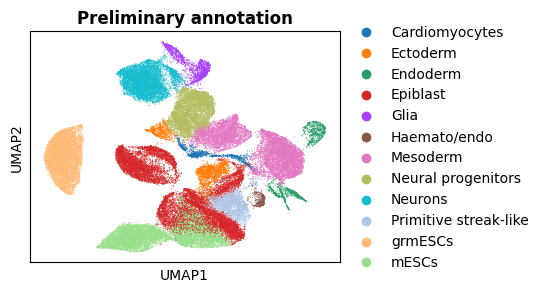

In [229]:

pl(alldata_batch, 'leiden_res0.5', 'Unintegrated CLustering')


The concatenated data is partitioned to batch-specific datasets, as this is the requirement of Scanorama.
Scanorama is a framework which utilises KNN to find mutual nearest neighbors between cells in the across several datasets in a simultaneous manner. 

In [167]:
batches = alldata.obs['batch'].unique()
adatas = [alldata[alldata.obs['batch'] == b].copy() for b in batches]

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [168]:
# adatas

In [169]:
sca.integrate_scanpy(adatas)
scanorama_int = [d.obsm['X_scanorama'] for d in adatas]

Found 2500 genes among all datasets
[[0.         0.03792842 0.02330946 0.49572118 0.04547221 0.03339296
  0.01410492]
 [0.         0.         0.12480272 0.03205228 0.02642829 0.02623733
  0.25147329]
 [0.         0.         0.         0.01384783 0.15856976 0.01610018
  0.06167294]
 [0.         0.         0.         0.         0.22658375 0.33691115
  0.10611483]
 [0.         0.         0.         0.         0.         0.52832439
  0.10454722]
 [0.         0.         0.         0.         0.         0.
  0.20632081]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
Processing datasets (4, 5)
Processing datasets (0, 3)
Processing datasets (3, 5)
Processing datasets (1, 6)
Processing datasets (3, 4)
Processing datasets (5, 6)
Processing datasets (2, 4)
Processing datasets (1, 2)
Processing datasets (3, 6)
Processing datasets (4, 6)


In [170]:
alldata_int = sc.concat(adatas, label='batch')

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [171]:
# alldata_int

scanorama_int are the Scanorama integrated spaces calculated for the different batch-specific dataset and we concatenate them with numpy. These integrated spaces can be used in place of PCA for the KNN graph and clustering. 
After integration always new clusters are calculated. This is the most imporatnt result of the integration. It creates a new model of the variation in the data which is naturally reflected in different KNN neigborhoods and finally the clustering reflects the changes that occured in the data and the new clustering is also then what carries the integration effects to subsequent annotation, DE analysis and etc.

In [172]:
alldata_int.obsm["Scanorama"] = np.concatenate(scanorama_int)

In [173]:
sc.pp.neighbors(alldata_int, use_rep = "Scanorama")
sc.tl.umap(alldata_int)

For all the integration embeddings we determined resolution 0.5 to be the most representative.

In [1]:
sc.tl.leiden(alldata_int, key_added="scanorama_0.5", resolution=0.5)
titles=['Batch Distribution', 'Preliminary Cell Type', 'Sample Distribution', 'Scanorama Integration 0.5']
pl(alldata_int, 'scanorama_0.5', titles)


SCVI

It is of importance to be sure that the raw counts are present in .X before scVI running

In [175]:
alldata.X=alldata.layers['raw']

In [35]:
a_scvi= alldata.copy()

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


To model the batch covariate we add it in the batch_key

In [36]:
scvi.model.SCVI.setup_anndata(a_scvi, layer=None, batch_key='batch')

We ran the integration with the default parameters (n_latent=10, n_layers=1). We note that though this was not performed in our analysis, scvi-tools actually recommends using batch-aware HVG selection before integration with scVI.

In [2]:
model_scvi=scvi.model.SCVI(a_scvi)
model_scvi.view_anndata_setup()

In [38]:

model_scvi.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


Epoch 126/126: 100%|█| 126/126 [24:37<00:00, 11.50s/it, v_num=1, train_loss_step=1.91e+3, 

`Trainer.fit` stopped: `max_epochs=126` reached.


Epoch 126/126: 100%|█| 126/126 [24:37<00:00, 11.73s/it, v_num=1, train_loss_step=1.91e+3, 


scVI is a variational inference deep neural network ensemble which encodes gene expression data into a latent representation of reduced dimensionality and also accounts for the zero-inflated distribution (e.g. the high dropout rates) of single-cell data.

In [4]:
adata_scvi = a_scvi.copy()
adata_scvi.obsm["X_scVI"] = model_scanvi.get_latent_representation()
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
sc.tl.leiden(adata_scvi, key_added="scVI_0.5", resolution=0.5)
titles=['Batch Distribution', 'Preliminary Cell Type', 'Sample Distribution', 'scVI Integration 0.5']
pl(adata_scvi, 'scVI_0.5', titles)

DE analysis can be performed with scVI but we approach it with caution due to its reliance on only the HVGs.

In [41]:
adata_scvi.layers['scvi_norm']= model_scanvi.get_normalized_expression()

In [54]:

diff=model_scvi.differential_expression(idx1=[(adata_scvi.obs['sample']=='5000_nM_RA')&(adata_scanvi.obs['scVI_0.5']=='10')],
                                          idx2=[(adata_scvi.obs['sample']=='20_nM_RA')&(adata_scanvi.obs['scVI_0.5']=='10')])

DE...: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


In [55]:
diff.to_csv('new_data/scvi_5000-20_HE')

SCANVI

HARMONY

In [181]:
alldata.X=alldata.layers['log1p_norm']

All integration methods (incl. Scanorama even though we ran it through its own package) except scVI are available in scanpy
Here we use harmony which calculates an integrated space in place of PCA
Harmony is originally implemented in R and we here use its Python-version package. It uses the so-called soft-clustering approach which allows freedom for error in cluster-assignment and favors clusters from multiple datasets. 

In [182]:
sc.external.pp.harmony_integrate(alldata, "batch")

2025-06-26 23:58:56,432 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-06-26 23:59:02,580 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-06-26 23:59:02,901 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-06-26 23:59:30,871 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-06-26 23:59:59,956 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-06-27 00:00:29,232 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


In [5]:
sc.pp.neighbors(alldata, use_rep="X_pca_harmony")
sc.tl.umap(alldata)
sc.tl.leiden(alldata, key_added="Harmony_0.5", resolution=0.5)
pl(alldata, 'Harmony_0.5', 'Harmony Integration 0.5')

BKNN

BBKNN is a rather straighforward approach which calculates neighbors for each cell in every separate batch and then creates a merged result. It is a very interpretable method which however may not work for our data very well considering the confounding of batch and condition covariates. Indeed, it simply lost all separation in the clustering.

In [13]:
sc.external.pp.bbknn(alldata, batch_key='batch', use_rep="X_pca", n_pcs=20)
sc.tl.umap(alldata)
sc.tl.leiden(alldata, key_added="BBKNN_0.5", resolution=0.5)
titles=['Batch Distribution', 'Preliminary Cell Type', 'Sample Distribution', 'BBKNN Integration 0.5']
pl(alldata, 'BBKNN_0.5', titles)

Finally, we transfer all integration results to the Anndata objects

In [188]:
scvi=adata_scanvi.obsm['X_scVI']
scanorama1=alldata_int.obsm['Scanorama']
harmony=alldata.obsm['X_pca_harmony']

In [189]:
alldata.obsm['X_scVI']=scvi
alldata.obsm['Scanorama']=scanorama1

In [190]:
alldata_full.obsm['X_scVI']=scvi
alldata_full.obsm['Scanorama']=scanorama1
alldata_full.obsm['X_pca_harmony']=harmony


In [191]:
alldata.write_h5ad(f'new_data/integrated/alldata_batch.h5ad', compression='gzip')
alldata_full.write_h5ad(f'new_data/integrated/alldata.h5ad', compression='gzip')

Here we demonstrate the use of several benchmarking metrics for integration as in Luecken et al., 2021, using their developed package scib. The metrics used here measure batch correction are KNN graph connectivity and average sllhoette score for batch effect removal per cell identity and local inverse Simpson Index (iLISI) and PCA regression for for cell label-independent batch removal testing. The metrics used to measure biological variation conservation were graph cLISI, Adjusted Rand Index (ARI), normalised mutual information (NMI) and isolated labels scores at both the cell label dependent and independednt level.

EVALUATION OF INTEGRATION with Scanorama, scANVI, scVI, Harmonypy and bbknn

In [187]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

In [11]:
bm = Benchmarker(
    alldata,
    batch_key="batch",
    label_key="manual_celltype_annotation",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    embedding_obsm_keys=["X_pca", "X_scVI", 'Scanorama', 'X_pca_harmony'],
    n_jobs=2,
)
bm.benchmark()


In [6]:

bm.plot_results_table()  


References:
1. Lopez, R., Regier, J., Cole, M.B. et al. Deep generative modeling for single-cell transcriptomics. Nat Methods 15, 1053–1058 (2018). https://doi.org/10.1038/s41592-018-0229-2
2. Gayoso, A., Lopez, R., Xing, G. et al. A Python library for probabilistic analysis of single-cell omics data. Nat Biotechnol 40, 163–166 (2022). https://doi.org/10.1038/s41587-021-01206-w
3. Hie, B., Bryson, B. & Berger, B. Efficient integration of heterogeneous single-cell transcriptomes using Scanorama. Nat Biotechnol 37, 685–691 (2019). https://doi.org/10.1038/s41587-019-0113-3
4. Krzysztof Polański, Matthew D Young, Zhichao Miao, Kerstin B Meyer, Sarah A Teichmann, Jong-Eun Park, BBKNN: fast batch alignment of single cell transcriptomes, Bioinformatics, Volume 36, Issue 3, February 2020, Pages 964–965, https://doi.org/10.1093/bioinformatics/btz625
5. Luecken, M.D., Büttner, M., Chaichoompu, K. et al. Benchmarking atlas-level data integration in single-cell genomics. Nat Methods 19, 41–50 (2022). https://doi.org/10.1038/s41592-021-01336-8
6. Korsunsky, I., Millard, N., Fan, J. et al. Fast, sensitive and accurate integration of single-cell data with Harmony. Nat Methods 16, 1289–1296 (2019). https://doi.org/10.1038/s41592-019-0619-0
7. Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet 24, 550–572 (2023). https://doi.org/10.1038/s41576-023-00586-w